# Ride Retention Challenge

Ultimate Technologies Inc. is an American worldwide online transportation network company headquartered in San Francisco, California. Founded by Jarvis Karolick in 2010, it has completely disrupted the taxi and logistics industry, and is one of the most prestigious companies to work for. This challenge has been adapted from an actual Ultimate Inc. data science challenge. 

## Part 1 - Exploratory Data Analysis
 

In [12]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [256]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
% matplotlib inline
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import scale

In [2]:
logins = pd.read_json('logins.json')

In [25]:
logins.head()
dtypeCount =[logins.iloc[:,i].apply(type).value_counts() for i in range(logins.shape[1])]
print (dtypeCount)
print (len(logins))

[<class 'float'>    9788
Name: count, dtype: int64]
9788


In [4]:
logins = logins.sort_values('login_time').set_index('login_time')
logins['count'] = 1
logins = logins.resample('15T').sum().fillna(0)

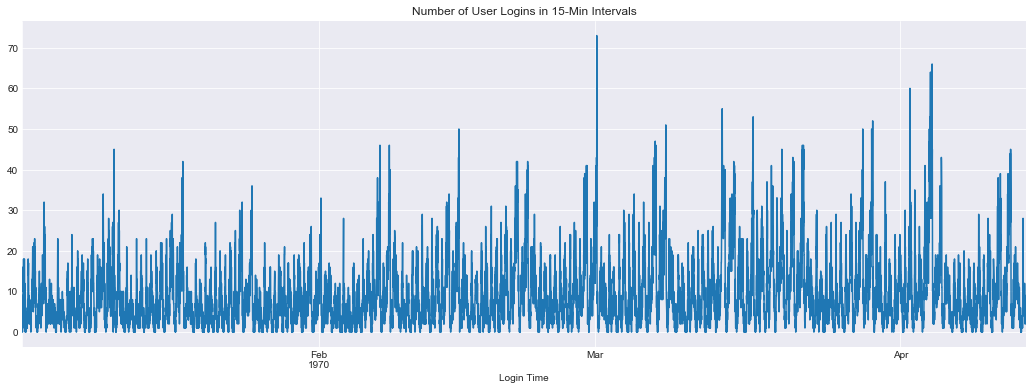

In [20]:
mpl.rcParams['figure.figsize'] = (18,6)
logins.plot(legend=False)
plt.title('Number of User Logins in 15-Min Intervals')
plt.xlabel('Login Time')
plt.show()

Looking at the above chart, we can see there looks to be a series of sharp spikes occurring through-out the day as well as potential seasonality, based off the repetitive trend lines we are seeing in the data.

This will require further inspection at a lower granularity before we can say anything further. 

Exploration Questions:
#### 1. Are there any obvious trends from looking at the past month's worth of data on a weekly grain?
#### 2. Can we group the data at an hourly level and take a more detailed look at when demand is most frequent? 
#### 3. Are there any particular day(s) which correspond to a higher amount of demand?

### Are there any obvious trends from looking at the past month's worth of data on a weekly grain?

Looking at the below trends, we can see that it is apparent that around lunch time, followed by later in the evening / early morning, there is an upward trend of rides being hailed. 

Of Particular interest is the times from 8PM to 11/12AM or so where the demand peaks and then drops. This is seen consistently; especially an associated rise in demand in the early hours of the morning.

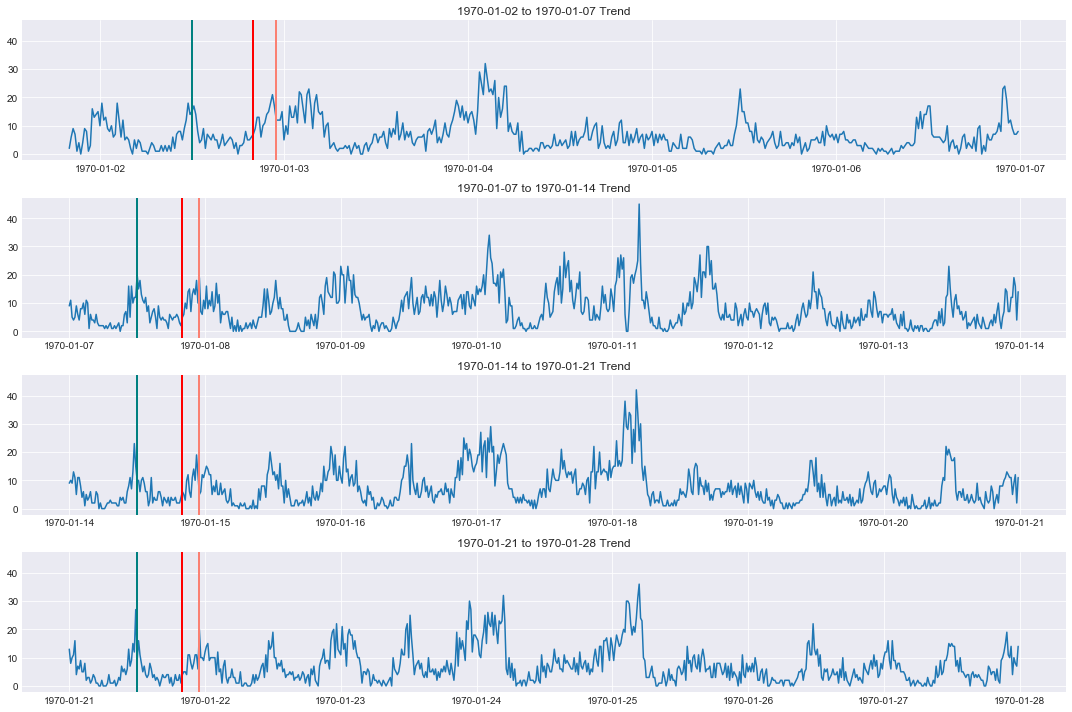

In [114]:
mpl.rcParams['figure.figsize'] = (15,10)
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharey=True)
d = logins[(logins.index >= '1970-01-01')&(logins.index <'1970-01-07')]
e = logins[(logins.index >= '1970-01-07')&(logins.index <'1970-01-014')]
f = logins[(logins.index >= '1970-01-14')&(logins.index <'1970-01-21')]
g = logins[(logins.index >= '1970-01-21')&(logins.index <'1970-01-28')]
ax1.plot(d)
ax1.axvline(x='1970-01-02 12:00', color='teal', linewidth='2')
ax1.axvline(x='1970-01-02 20:00', color='red', linewidth='2')
ax1.axvline(x='1970-01-02 23:00', color='salmon', linewidth='2')
ax1.set_title("1970-01-02 to 1970-01-07 Trend")

ax2.plot(e)
ax2.axvline(x='1970-01-07 12:00', color='teal', linewidth='2')
ax2.axvline(x='1970-01-07 20:00', color='red', linewidth='2')
ax2.axvline(x='1970-01-07 23:00', color='salmon', linewidth='2')
ax2.set_title("1970-01-07 to 1970-01-14 Trend")

ax3.plot(f)
ax3.axvline(x='1970-01-14 12:00', color='teal', linewidth='2')
ax3.axvline(x='1970-01-14 20:00', color='red', linewidth='2')
ax3.axvline(x='1970-01-14 23:00', color='salmon', linewidth='2')
ax3.set_title("1970-01-14 to 1970-01-21 Trend")

ax4.plot(g)
ax4.axvline(x='1970-01-21 12:00', color='teal', linewidth='2')
ax4.axvline(x='1970-01-21 20:00', color='red', linewidth='2')
ax4.axvline(x='1970-01-21 23:00', color='salmon', linewidth='2')
ax4.set_title("1970-01-21 to 1970-01-28 Trend")

plt.tight_layout()
plt.show()


#### 2. Can we group the data at an hourly level and take a more detailed look at when demand is most frequent? 

Grouping the data below seems to indicate we see the most activity in the following hours:
12:00 - 4/5AM.
This then sees a sharp gradient decrease from ~ 5 to about 10AM.
At 11AM there is an upward surge which is then followed by a downward trajectory with a minima reached at ~ 5PM.

From this point, there is a gradual increase in activity with 'log-ins' spiking ~ 21:00 through to 4/5AM the next day.



In [115]:
hourly_logins = logins.resample('1H').sum()
hourly_logins['hour'] = hourly_logins.index.hour

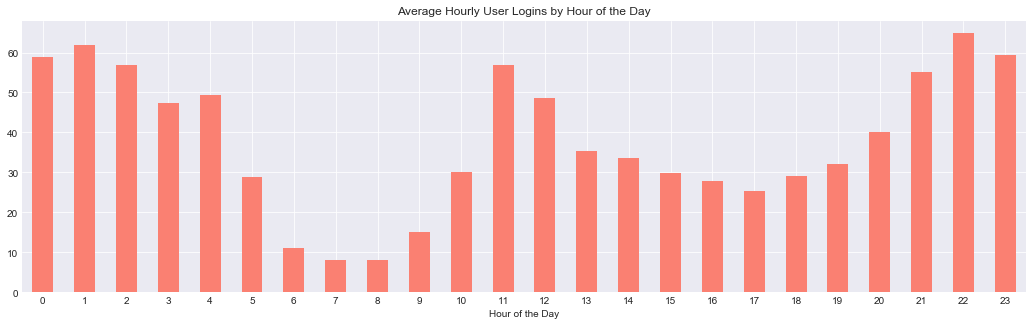

In [130]:
mpl.rcParams['figure.figsize'] = (18,5)
hourly_logins.groupby('hour').mean().plot(kind='bar', color='salmon', legend=False)
plt.title('Average Hourly User Logins by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.xticks(range(0,24), rotation=0)
plt.show()

### Are there any particular day(s) which correspond to a higher amount of demand?

From the graph below, we can see that demand looks to mirror a linear step wise function.
On Thursday through to Saturday however, the gradient changes much quicker as oppposed to Monday through to Wednesday.
This most likely coincides due to the Weekend Activity being highest then.

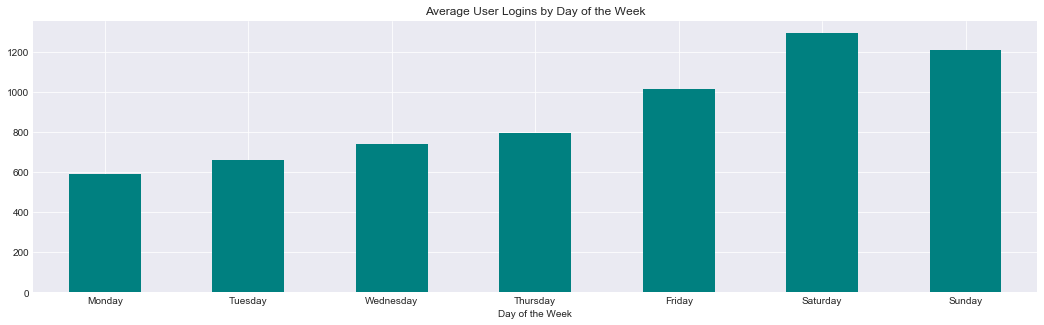

In [133]:
daily_logins = logins.resample('1D').sum()
daily_logins['day'] = daily_logins.index.day
daily_logins['dayofweek'] = daily_logins.index.dayofweek
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax = daily_logins.groupby('dayofweek')['count'].mean().plot(kind='bar', color='teal', legend=False)
ax.set_xticklabels(labels, rotation=0)
plt.title('Average User Logins by Day of the Week')
plt.xlabel('Day of the Week')
plt.show()

## Part 2 - Experiment and Metrics Design 

Gotham and Metropolis are two neighboring cities that have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. 

However, a toll bridge, with a two-way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs. 

### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric? 

At the end of the day, this is a service that is being offered; With that in mind,  logically it follows that there are tangible incentives that need to be adhered towards to encourage people to serve both cities. Take for example, staff working on weekends. In Australia, we have a concept called 'Penalty Rates', which means people which work weekends are entitled to 1.5x their normal pay.

As Ultimate Inc. (I assume) records drivers earnings, with this in mind, there should be a few measure(s) we can use:
1. **Number of Driver Change over %**  - Essentially # of Drivers travelling to both Gotham and Metropolis (Before vs. After). Assuming there is a unique-id assigned to each driver, we can see proportionally for drivers, whether they have decided to serve both cities or stick to the one. We can Set up a two-tailed t-test to see if there are significant statistical change(s) in #'s of drivers now earning revenues from both cities.

2. ** Gross Revenue Gain - Essentially COGS. Revenue - COGS (Toll Price)** . Provided GRG is continually greater (i.e. statistically significant) with the implementation of the toll refund, it is likely the experiment is successful. 


### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on: 

1) How  you will implement the experiment

2) Statistical Tests you will conduct

3) Any risks

As indicated above, we will need a control group and a test group. The control group will be a random selection from the population of drivers which will not have any change(s) applied to them (i.e. reimbursement of toll costs). The test group will be a random selection of drivers which WILL have the reimbursement of toll groups applied to them. Now as we are interested in showing whether the population means are significantly different after the experiment, we can use a two-tailed test to validate this. 

Risk Wise, apart from potential financial risk if a greater number than expected drivers switch-over, there shouldn't need to be any other concerns (provided other factors are consistent I.e. supply demand has not shifted significantly to result in understaffing).

## Part 3   Predictive modeling 

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider **a user retained if they were “active” (i.e. took a trip) in the preceding 30 days**. We would like you to use this data set to help understand **what factors are the best predictors for retention, and offer suggestions to operationalize those insights** to help Ultimate. The data is in the attached file `ultimate_data_challenge.json`. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge. 

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained? 
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. 
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long-term rider retention (again, a few sentences will suffice). 

### Data description 

* city: city this user signed up in 
* phone: primary device for this user 
* signup_date: date of account registration; in the form ‘YYYYMMDD’ 
* last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’ 
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup 
* avg_rating_by_driver: the rider’s average rating over all of their trips 
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips 
* surge_pct: the percent of trips taken with surge multiplier > 1 
* avg_surge: The average surge multiplier over all of this user’s trips 
* trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up 
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

This is a purely classification problem where Ultimate Inc. is interested in identifying what key feature(s) contribute towards user retention.
As such, I will use the following algorithm(s) to identify key features:
    
    1) Logistic Regression
    2) Random Forest


In [186]:
with open('ultimate_data_challenge.json') as file:
    data = json.load(file)
df = pd.DataFrame(data)

In [137]:
df.head()
#I approve of the Game of Thrones References - very good. 

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [138]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Taking a look at the above dataframe, we can see that we have a number of missing values for the following:
avg_rating_by_driver
avg_rating_of_driver
phone

The easiest way is to drop rows which don't have the data - PROVIDED, it does not result in significant differences in data shape.
Let's take a look.

In [187]:
missing_values_avg_rating_by_driver = len(df[df.avg_rating_by_driver.isnull()])
missing_values_avg_rating_of_driver = len(df[df.avg_rating_of_driver.isnull()])
missing_phone = len(df[df.phone.isnull()])

print ("Missing values in avg_rating_by_driver as a % is", missing_values_avg_rating_by_driver/len(df.avg_rating_by_driver)*100)
print ("Missing values in avg_rating_of_driver as a % is", missing_values_avg_rating_of_driver/len(df.avg_rating_of_driver)*100)
print ("Missing values in phone as a % is", missing_phone/len(df.phone)*100)

Missing values in avg_rating_by_driver as a % is 0.402
Missing values in avg_rating_of_driver as a % is 16.244
Missing values in phone as a % is 0.792


It is not feasible to drop 16.2% of the data-set when there are other feature(s) which is useful. 

As such, we will use filling measures to fill the missing data that currently exists via the mean.

In [188]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

Lastly, for the missing 'phones' data, we can either fill it with 'missing', or in this case, look at whether or not dropping the rows from phone is significant or not. 

In this context, it would mean we lose 0.79% of the data set. 
Which means we would retain 99.21% - In my mind, this trade-off is more acceptable than filling it with 'unknown'.

In [189]:
df.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

In [192]:
# phone_filt = df['phone'] != 'Unknown'
filt = ((df.phone == 'Android') | (df.phone == 'iPhone'))
df = df[filt]

In [140]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

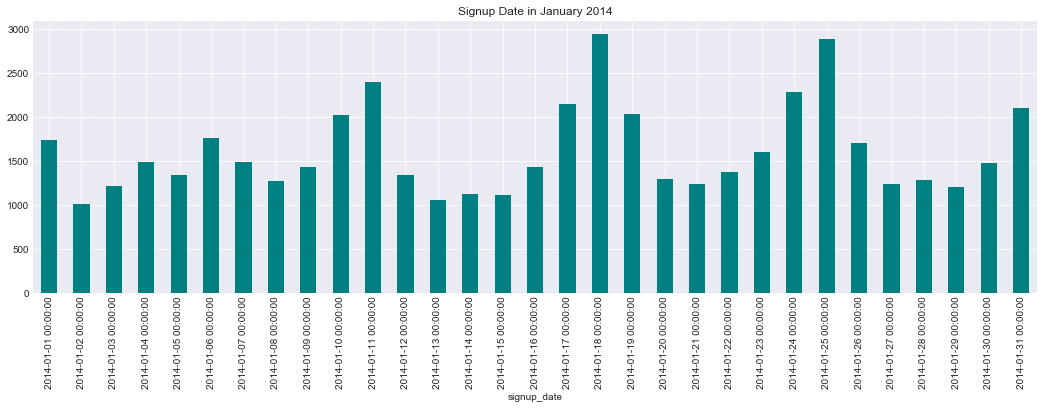

In [144]:
ax = df.groupby('signup_date').size().plot(kind='bar', color='teal', legend=False)
plt.title('Signup Date in January 2014')
plt.show()

In [193]:
sorted(df['last_trip_date'].unique())[-10:]

['2014-06-22',
 '2014-06-23',
 '2014-06-24',
 '2014-06-25',
 '2014-06-26',
 '2014-06-27',
 '2014-06-28',
 '2014-06-29',
 '2014-06-30',
 '2014-07-01']

**User Retention:** A user is retained if the date of the last trip is on or after June 1, 2014 (which is within 30 days preceding July 1, 2014). 

With this in mind, we can see from the above that the last date data was collected was on 1st July, 2014.
To meet the 'user retention' criteria, our retention date will be 1st June, 2014. 


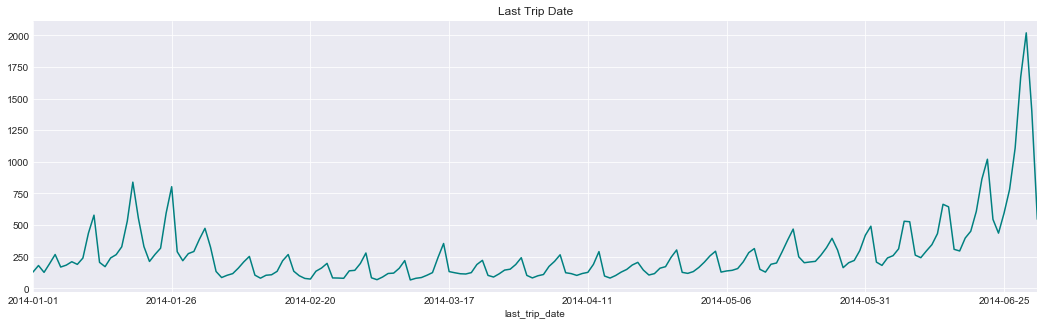

In [205]:
ax = df.groupby('last_trip_date').size().plot(kind='line', color='teal', legend=False)
plt.title('Last Trip Date')
plt.show()


In [206]:
df['user_retain'] = (df.last_trip_date >= '2014-06-01')

In [212]:
frac_user_retain = df.user_retain.sum() / len(df)
print('The fraction of users that are retained is', frac_user_retain*100)

The fraction of users that are retained is 37.6401096686


In [273]:
filt = df.user_retain == True
retained_df = df[filt]

retained_df.mean()

avg_dist                   5.113930
avg_rating_by_driver       4.762740
avg_rating_of_driver       4.593778
avg_surge                  1.073834
surge_pct                  9.165615
trips_in_first_30_days     3.304804
ultimate_black_user        0.503990
weekday_pct               61.344208
user_retain                1.000000
dtype: float64

In [274]:
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,user_retain
0,3.67,5.0,4.700000,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.000000,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.300000,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.600000,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.400000,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False
5,10.56,5.0,3.500000,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,True
6,3.95,4.0,4.601559,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,False
7,2.04,5.0,5.000000,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0,False
8,4.36,5.0,4.500000,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0,False
9,2.37,5.0,4.601559,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,False


#### Machine Learning - Identifying what feature(s) lead to a user being 'retained' or not

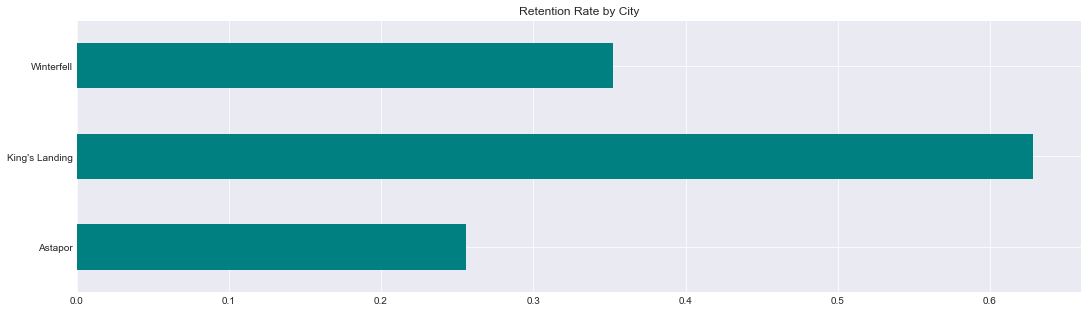

In [215]:
df.groupby('city')['user_retain'].mean().plot(kind='barh', color='teal')
plt.title("Retention Rate by City")
plt.ylabel('')
plt.show()

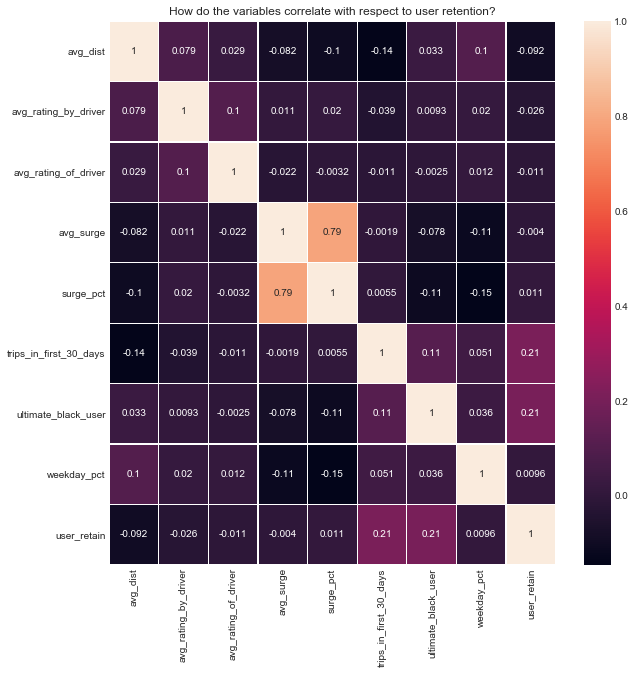

In [228]:
# Correlation Heatmap - With Raw Feature(s) not transformed - how do we look?
corr = df.corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr, annot=True,linewidths=.1,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)
plt.title("How do the variables correlate with respect to user retention?")
plt.show()


From looking at the above correlation matrix, we can see that only two feature(s) seem to correlate
with user retention. This is the trips_in_first_30_days and whether they are an ultimate_black_user.


Now that we have run our correlation matrix, we will use a CART and see if we can verify whether
the 2 features, trips_in_first_30_days and ultimate_black_user are significant features.

The reason we have chosen to focus on using trees for this is that they require the least amount of training data to run
and aren't particularly biased if we need to account for colinearity between features. 

In [250]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

# Create train and test splits and encode all categorical variables
df_onehot = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])
variables = df_onehot.drop(['user_retain', 'signup_date', 'last_trip_date'],axis=1)
X = variables
y = df['user_retain']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y)

y_test_prop = float(y_test.sum())/len(y_test)
y_train_prop = float(y_train.sum())/len(y_train)

print ("Proportion of positive cases in training set: ", y_train_prop)
print ("Proportion of positive cases in test set: ", y_test_prop)

Proportion of positive cases in training set:  0.3763943767975701
Proportion of positive cases in test set:  0.37642125635029433


In [264]:
df

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,user_retain
0,3.67,5.0,4.700000,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,True
1,8.26,5.0,5.000000,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,False
2,0.77,5.0,4.300000,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,False
3,2.36,4.9,4.600000,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,True
4,3.13,4.9,4.400000,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,False
5,10.56,5.0,3.500000,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,True
6,3.95,4.0,4.601559,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,False
7,2.04,5.0,5.000000,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0,False
8,4.36,5.0,4.500000,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0,False
9,2.37,5.0,4.601559,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,False


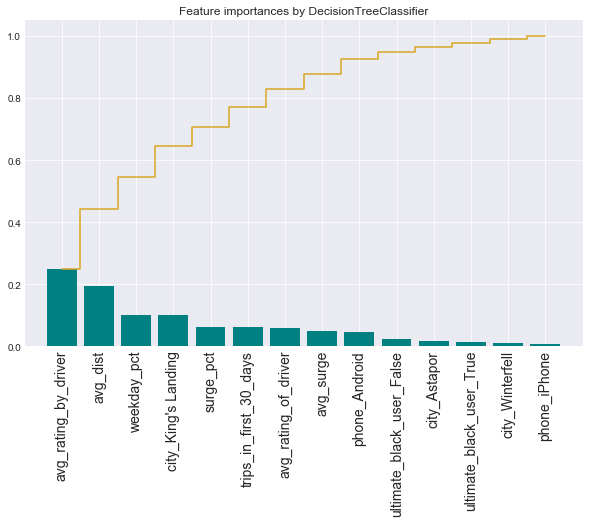

In [254]:
dtree = tree.DecisionTreeClassifier(
    max_depth=15
    )
dtree = dtree.fit(X_train,y_train)

importances = dtree.feature_importances_
feat_names = X.columns

indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.title("Feature importances by DecisionTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='teal',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative',color='goldenrod')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [257]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10)
rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % rf_roc_auc)
print(classification_report(y_test, rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.75
             precision    recall  f1-score   support

      False       0.80      0.86      0.83      7733
       True       0.73      0.63      0.68      4668

avg / total       0.77      0.77      0.77     12401



In [ ]:
cv_results = cross_val_score(rf, X,y, cv=5)
print (cv_results)

In [ ]:
avg_dist                   5.113930
avg_rating_by_driver       4.762740
avg_rating_of_driver       4.593778
avg_surge                  1.073834
surge_pct                  9.165615
trips_in_first_30_days     3.304804
ultimate_black_user        0.503990
weekday_pct               61.344208


### Recommendations

From the CART, we can see that users are more likely to remain active in their 6th month if they were:

1. Avg Rating by Driver - Given good reviews by the Uber Drivers (Avg. Rating by Driver 4.76)
2. Avg Distance - Frequently Travel and rack up a certain # of average trips withint the first 30 days ( Avg. Dist 5.1 miles )
2. Weekday % - Take an average of 61% of the trips during the weekday
4. City - Take trips to Kings Landing
5. Surge - Take an average of 9% surge trips Take more trips in their first 30 days

So if Ultima Inc. wants to improve their offerings, the two options I would recommend:
1. As Ratings seem to be of significance for both Driver / User - Send out surveys to users which consistently give low driver ratings / low user scores
2. Improve promotional offerings by encouraging users to take more weekday trips in their first 30 days of joining by offering lower discounts
